In [1]:
import numpy as np
from netCDF4 import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from scipy import stats
from scipy.stats import pearsonr

In [2]:
START_YEAR                  = 1951 
END_YEAR                    = 2010 
MAX_WIND_threshold_lifetime = 64.0 # unit: kt
MAX_WIND_threshold          = 0
LAT_lower_threshold         = 13.0 # degrees North
LAT_upper_threshold         = 30.0
LON_lower_threshold         = 120.0 # degrees East
LON_upper_threshold         = 153.0
kt_m_convert                = 0.514444 # kt to m/s conversion factor
MAX_WIND_threshold_m        = MAX_WIND_threshold_lifetime * kt_m_convert # unit: m/s

nc_ibtracs = '/Users/theorashid/Documents/2015 October-/SPAT/trackdat/Allstorms.ibtracs_all.v03r09.nc'
ibt = Dataset(nc_ibtracs)

name          = ibt.variables['name'][:]
genesis_basin = ibt.variables['genesis_basin'][:]
season        = ibt.variables['season'][:]
time_record   = ibt.variables['source_time'][:]
lat           = ibt.variables['source_lat'][:]
lon           = ibt.variables['source_lon'][:]
max_wind      = ibt.variables['source_wind'][:] # dimensions (12755, 191, 26)
min_pres      = ibt.variables['source_pres'][:]
landfall      = ibt.variables['landfall'][:]

# only JTWC Western Pacific data
# 10 - WP - jtwc_wp
for INDEX_RECORD_SOURCE in [10]:
    LAT         = np.nan * np.ones(shape=(np.size(lat,0),np.size(lat,1)))
    LON         = np.nan * np.ones(shape=(np.size(lat,0),np.size(lat,1)))
    MAX_WIND    = np.nan * np.ones(shape=(np.size(lat,0),np.size(lat,1)))
    TIME_RECORD = np.nan * np.ones(shape=(np.size(lat,0),np.size(lat,1)))
    LAT      [:,:] = lat[:,:,INDEX_RECORD_SOURCE]
    LON      [:,:] = lon[:,:,INDEX_RECORD_SOURCE]
    MAX_WIND [:,:] = max_wind[:,:,INDEX_RECORD_SOURCE] # dimensions (12755, 191)
    TIME_RECORD = time_record.data[:]

In [3]:
# only data between 1951 and 2010
INDEX_year = range(START_YEAR, END_YEAR + 1) # list of years from 1951 - 2010 (inclusive)
for i in range(np.size(season)):
    if season[i] not in INDEX_year:
        MAX_WIND[i,:] = np.nan

In [4]:
# # Select genesis basins. Useful: 2 = WP - West Pacific; 3 = EP - East Pacific, 4 = SP - South Pacific
# genesis_basin_list = [2]
# for i in range(np.size(genesis_basin)):
#     if genesis_basin[i] not in genesis_basin_list:
#         MAX_WIND[i,:] = np.nan

In [5]:
MAX_WIND[MAX_WIND == -9990.] = np.nan

In [6]:
# ONLY FOR JTWC data before 1973. Corrections according to 'Hurricane Data in netCDF Format
for i in range(np.size(season)):
    if season[i] <= 1967:
        MAX_WIND[i,:] = MAX_WIND[i,:]*0.4 + 0.6*0.1884*MAX_WIND[i,:]**1.288
    elif season[i] in range(1968, 1972 + 1):
        MAX_WIND[i,:] = MAX_WIND[i,:]*0.8 + 0.2*0.1884*MAX_WIND[i,:]**1.288

In [7]:
# only data from TCs above hurricane threshold - 64kt
MAX_WIND[MAX_WIND < MAX_WIND_threshold] = np.nan
MAX_WIND[np.nanmax(MAX_WIND, 1) <= MAX_WIND_threshold_lifetime,:] = np.nan

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: All-NaN slice encountered
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less_equal
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# Using the MAX_WIND array as a mask, if NaN in MAX_WIND, it will be NaN for the following
LAT         [np.isnan(MAX_WIND)] = np.nan
LON         [np.isnan(MAX_WIND)] = np.nan
TIME_RECORD [np.isnan(MAX_WIND)] = np.nan

In [9]:
# Create a dataframe. Headings are LAT, LON, YEAR, VMAX, CycNo and TIME_RECORD
cyclone_dataset = pd.DataFrame({'LAT':LAT[0],'LON':LON[0],'YEAR':season[0],'VMAX':MAX_WIND[0],'CycNo':0, 'TIME_RECORD':TIME_RECORD[0]})
i = 1
while i < len(season):
    #print '%i/12755' %i
    temp = pd.DataFrame({'LAT':LAT[i],'LON':LON[i],'YEAR':season[i],'VMAX':MAX_WIND[i],'CycNo':i, 'TIME_RECORD':TIME_RECORD[i]})
    cyclone_dataset = pd.concat([cyclone_dataset,temp],ignore_index=True)
    i+=1

In [10]:
# Raw tabular data for cyclones, ignores year change error. TIMESTAMP added to see hourly progression
cyclones = cyclone_dataset[np.isfinite(cyclone_dataset['VMAX'])]
# convert from kt to m/s
cyclones['VMAX'] = cyclones['VMAX']*kt_m_convert
cyclones['TIMESTAMP'] = pd.to_datetime('1858-11-17', format='%Y-%m-%d') + pd.to_timedelta(cyclones.TIME_RECORD, unit='d')
cyclones = cyclones.reset_index(drop=True)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [11]:
cyclones

CycNo        LAT         LON  TIME_RECORD       VMAX  YEAR  \
0       5453   8.599999  168.000000     33725.00  23.692298  1951   
1       5453   8.500000  168.800003     33725.25  28.241897  1951   
2       5453   8.500000  169.500000     33725.50  32.896468  1951   
3       5453   8.500000  170.099991     33725.75  35.260049  1951   
4       5453   8.599999  170.800003     33726.00  37.646444  1951   
5       5453   8.800000  171.500000     33726.25  42.484122  1951   
6       5453   9.000000  171.800003     33726.50  47.403142  1951   
7       5453   9.500000  172.000000     33726.75  52.398155  1951   
8       5453  10.000000  172.099991     33727.00  47.403142  1951   
9       5453  10.200000  172.000000     33727.25  42.484122  1951   
10      5453  10.599999  171.699997     33727.50  42.484122  1951   
11      5453  10.800000  171.399994     33727.75  42.484122  1951   
12      5453  10.900000  171.099991     33728.00  47.403142  1951   
13      5453  11.000000  170.000000     33728.25  42.484122  1951   
14      5453  11.099999  169.000000     33728.50  35.260049  1951   
15      5453  11.000000  168.000000     33728.75  28.241897  1951   
16      5453  10.599999  167.000000     33729.00  19.259937  1951   
17      5453  10.099999  165.800003     33729.25  17.092629  1951   
18      5453  10.000000  164.199997     33729.50  14.961235  1951   
19      5453  10.200000  163.099991     33729.75  12.868912  1951   
20      5453  10.800000  162.099991     33730.00  12.868912  1951   
21      5459   7.300000  142.800003     33765.50  12.868912  1951   
22      5459   7.400000  142.399994     33765.75  17.092629  1951   
23      5459   7.800000  141.800003     33766.00  21.460557  1951   
24      5459   8.200000  141.099991     33766.25  23.692298  1951   
25      5459   8.500000  140.199997     33766.50  25.953285  1951   
26      5459   8.800000  139.399994     33766.75  25.953285  1951   
27      5459   9.000000  137.800003     33767.00  25.953285  1951   
28      5459   9.000000  136.800003     33767.25  28.241897  1951   
29      5459   9.200000  135.800003     33767.50  28.241897  1951   
...      ...        ...         ...          ...        ...   ...   
35193  12253  15.599999  134.099991     55492.25  10.288880  2010   
35194  12253  15.500000  133.699997     55492.50  12.861100  2010   
35195  12253  15.500000  133.300003     55492.75  12.861100  2010   
35196  12253  15.500000  132.899994     55493.00  12.861100  2010   
35197  12253  15.700000  132.399994     55493.25  15.433320  2010   
35198  12253  16.000000  131.699997     55493.50  15.433320  2010   
35199  12253  16.400000  131.099991     55493.75  18.005540  2010   
35200  12253  16.900000  130.800003     55494.00  23.149980  2010   
35201  12253  17.500000  130.399994     55494.25  28.294420  2010   
35202  12253  18.100000  129.899994     55494.50  30.866640  2010   
35203  12253  18.799999  129.399994     55494.75  33.438860  2010   
35204  12253  19.500000  129.099991     55495.00  36.011080  2010   
35205  12253  19.900000  128.599991     55495.25  36.011080  2010   
35206  12253  20.199999  128.199997     55495.50  41.155520  2010   
35207  12253  20.400000  127.899994     55495.75  46.299960  2010   
35208  12253  20.900000  127.799995     55496.00  48.872180  2010   
35209  12253  21.600000  127.899994     55496.25  51.444400  2010   
35210  12253  22.400000  128.000000     55496.50  56.588840  2010   
35211  12253  23.299999  128.300003     55496.75  56.588840  2010   
35212  12253  24.199999  128.599991     55497.00  59.161060  2010   
35213  12253  24.900000  129.199997     55497.25  59.161060  2010   
35214  12253  25.599998  130.199997     55497.50  56.588840  2010   
35215  12253  26.400000  130.800003     55497.75  54.016620  2010   
35216  12253  27.099998  131.599991     55498.00  51.444400  2010   
35217  12253  28.199999  132.800003     55498.25  46.299960  2010   
35218  12253  29.299999  134.099991     55498.50  46.299960  2010   
35219

In [12]:
# cyclones.to_csv('cyclones_JTWC.csv',index=False)

In [13]:
# Number of cyclones
cyclones[np.isfinite(cyclones['VMAX'])]['CycNo'].nunique()

939

In [14]:
# # Regional box contraints, edit lat/lon in line 2
# def region_check(row):
#     lat = row['LAT']
#     lon = row['LON']
#     if lat <= LAT_upper_threshold and lat >= LAT_lower_threshold and lon <= LON_upper_threshold and lon >= LON_lower_threshold:
#         return True
#     else:
#         return False
# def region_check2(series):
#     if any(series['REGION']):
#         return True
#     else:
#         return False

In [15]:
# cyclones['REGION'] = cyclones.apply(region_check, axis = 1)
# region_result = cyclones.groupby('CycNo').apply(region_check2)
# cyclones = cyclones.merge(region_result.reset_index(), on ='CycNo', how='inner')
# cyclones = cyclones[cyclones[0]==True]

In [16]:
# For cyclones that cross over two years, able to take the modal average for the cyclone year
year_occur = cyclones.groupby('CycNo')['YEAR'].agg(lambda x: stats.mode(x)[0][0]).reset_index()

In [17]:
vmax_peak = cyclones.groupby('CycNo')['VMAX'].max().reset_index()

In [18]:
'''
Function to work out the intensification duration
Duration defined as the time from the start of cyclone (>33m/s) to the maximum intensity
'''
def duration(data):
    time_1 = data[data['VMAX'] >= MAX_WIND_threshold_m].iloc[0]['TIME_RECORD']
    time_max = data['TIME_RECORD'][data['VMAX'].idxmax()]
    return time_max - time_1
cyclone_duration = cyclones.groupby('CycNo').apply(duration)

In [19]:
# Method to determine intensification rate
def int_rate(data):
    data = data[(data.index >= data[data['VMAX'] >= MAX_WIND_threshold_m].index[0]-1) & (data.index <= data['VMAX'].idxmax()+1)]
    data = data.set_index('TIMESTAMP')
    data = data.resample('6h').interpolate(method='time').reset_index()
    result = data['VMAX'].rolling(min_periods=3, window=3, center=True).apply(lambda x: (x[2] - x[0])/2)
    return result.mean()
ave_int = cyclones.groupby('CycNo').apply(int_rate)

In [20]:
# Method to determine first windspeed value at hurricane level
def v_0_method(data):
    v_cyclone_0 = data[data['VMAX'] >= MAX_WIND_threshold_m].iloc[0]['VMAX']
    return v_cyclone_0
v_0 = cyclones.groupby('CycNo').apply(v_0_method)

In [21]:
temp1 = year_occur.merge(vmax_peak, on ='CycNo', how='inner')
temp2 = cyclone_duration.to_frame().join(temp1.set_index('CycNo'), how='left').reset_index()
temp2.columns.values[1] = 'Duration'
temp3 = ave_int.to_frame().join(temp2.set_index('CycNo'), how='left').reset_index()
temp3.columns.values[1] = 'Intensification'
temp4 = v_0.to_frame().join(temp3.set_index('CycNo'), how='left').reset_index()
temp4.columns.values[1] = 'v_0'
cyclone_statistics = temp4[['CycNo', 'YEAR', 'VMAX', 'v_0', 'Duration', 'Intensification']]

In [22]:
cyclone_statistics

CycNo  YEAR       VMAX        v_0  Duration  Intensification
0     5453  1951  52.398155  35.260049      1.00         3.164478
1     5459  1951  67.796341  37.646444      1.25         4.987658
2     5468  1951  42.484122  35.260049      0.25         4.202932
3     5481  1951  52.398155  35.260049      2.25         1.831990
4     5490  1951  42.484122  35.260049      1.25         1.400977
5     5495  1951  42.484122  35.260049      0.50         1.995675
6     5504  1951  35.260049  35.260049      0.00         1.181790
7     5506  1951  37.646444  37.646444      0.00        -1.169879
8     5511  1951  52.398155  35.260049      2.25         1.706655
9     5517  1951  42.484122  37.646444      0.75         1.803166
10    5518  1951  54.922704  37.646444      1.75         2.456406
11    5521  1951  37.646444  35.260049      0.50         1.189395
12    5527  1951  52.398155  35.260049      3.25         1.694594
13    5530  1951  42.484122  37.646444      0.25         3.606333
14    5563  1952  35.260049  35.260049      0.00         3.509076
15    5568  1952  47.403142  42.484122      0.25         4.856424
16    5575  1952  42.484122  35.260049      0.50         1.995675
17    5583  1952  35.260049  35.260049      0.00         1.181790
18    5598  1952  73.055121  40.054745      1.75         4.718674
19    5609  1952  52.398155  37.646444      0.75         4.281675
20    5617  1952  73.055121  35.260049      2.00         4.589350
21    5620  1952  67.796341  35.260049      2.25         3.488796
22    5621  1952  42.484122  35.260049      1.25         1.400977
23    5623  1952  47.403142  37.646444      0.75         3.032921
24    5624  1952  67.796341  37.646444      2.00         3.743863
25    5636  1952  57.464587  37.646444      1.00         4.438626
26    5639  1952  73.055121  35.260049      2.25         3.897686
27    5649  1953  42.484122  42.484122      0.00        -2.301713
28    5664  1953  52.398155  37.646444      1.75         2.140837
29    5668  1953  67.796341  42.484122      1.25         5.017674
..     ...   ...        ...        ...       ...              ...
909  12025  2008  48.872180  33.438860      1.25         2.357868
910  12035  2008  51.444400  33.438860      1.50         2.755950
911  12045  2008  64.305500  33.438860      1.50         4.960710
912  12049  2008  64.305500  33.438860      2.00         3.429627
913  12050  2008  72.022160  33.438860      2.00         4.572836
914  12078  2008  43.727740  33.438860      0.75         2.893748
915  12104  2009  59.161060  33.438860      0.75         7.073605
916  12105  2009  46.299960  33.438860      0.75         2.572220
917  12108  2009  38.583300  33.438860      0.50         1.714813
918  12119  2009  33.438860  33.438860      0.00         1.286110
919  12125  2009  41.155520  38.583300      0.25         3.215275
920  12132  2009  61.733280  33.438860      2.25         3.086664
921  12137  2009  33.438860  33.438860      0.00         0.000000
922  12147  2009  38.583300  33.438860      0.25         1.929165
923  12148  2009  72.022160  33.438860      2.00         4.429934
924  12151  2009  46.299960  33.438860      0.50         4.715737
925  12154  2009  69.449940  36.011080      1.00         6.944994
926  12157  2009  77.166600  36.011080      3.25         3.123410
927  12161  2009  72.022160  33.438860      2.75         3.108099
928  12165  2009  46.299960  33.438860      0.75         3.858330
929  12172  2009  79.738820  33.438860      1.25         8.145363
930  12214  2010  41.155520  36.011080      3.50         0.342963
931  12216  2010  41.155520  36.011080      0.25         2.572220
932  12224  2010  33.438860  33.438860      0.00         0.000000
933  12229  2010  54.016620  36.011080      1.75         2.411456
934  12236  2010  33.438860  33.438860      0.00         3.858330
935  12239  2010  54.016620  33.438860      1.75         2.732984
936  12241  2010  46.299960  33.438860      1.00         3.086664
937  12250  2010  82.311040  36.011080      3

In [23]:
# cyclone_statistics.to_csv('cyclone_statistics_JTWC.csv',index=False)

In [24]:
# Number of cyclones with some duration
cyclone_statistics[np.isfinite(cyclone_statistics['Intensification'])]['CycNo'].nunique()

937

In [25]:
# Take only cyclones with a non-NaN intensification
cyclone_statistics = cyclone_statistics[np.isfinite(cyclone_statistics['Intensification'])]

In [26]:
annual_cyclones = cyclone_statistics.groupby(['YEAR']).agg({'VMAX'            : np.mean,
                                                            'v_0'             : np.mean,
                                                            'Duration'        : np.mean,
                                                            'Intensification' : np.mean}).reset_index()
annual_cyclones['VMAX Estimated'] = MAX_WIND_threshold_m + annual_cyclones['Duration']*annual_cyclones['Intensification']*4

In [27]:
annual_cyclones

YEAR       VMAX  Duration        v_0  Intensification  VMAX Estimated
0   1951  46.806087  1.089286  36.112333         2.146584       42.277387
1   1952  54.993493  1.134615  36.918845         3.471964       48.681792
2   1953  53.817964  1.696429  39.212999         2.616546       50.679551
3   1954  52.201303  0.687500  36.657520         4.604722       45.587401
4   1955  51.610338  1.458333  36.653938         3.467086       53.149081
5   1956  51.060042  1.557692  38.618110         1.869411       44.572288
6   1957  53.722713  1.750000  38.220688         2.719154       51.958491
7   1958  57.834675  2.062500  39.040864         3.366307       60.696450
8   1959  57.188502  1.416667  39.124831         4.210904       56.786206
9   1960  49.157989  1.062500  38.271451         2.712183       44.451195
10  1961  60.754940  1.590909  37.658242         3.317577       54.036273
11  1962  53.761373  1.211538  37.841559         3.555089       50.152922
12  1963  53.691884  1.433333  35.737328         2.965446       49.926305
13  1964  55.686933  1.800000  36.861091         3.215091       56.073073
14  1965  57.956053  1.406250  37.524378         4.063019       55.778900
15  1966  45.463078  0.890625  35.856648         2.594689       42.167997
16  1967  51.152101  1.053571  36.809240         2.990431       45.526949
17  1968  55.101154  1.426471  34.591431         3.129853       50.782987
18  1969  49.577873  1.770833  34.250851         2.123579       47.966433
19  1970  61.225338  1.979167  34.873148         2.848906       55.478258
20  1971  50.862061  1.510870  34.394298         2.907878       50.498114
21  1972  50.659887  1.750000  35.288587         2.466132       50.187339
22  1973  49.943938  1.125000  34.296267         2.951801       46.207521
23  1974  44.370795  1.531250  33.599624         1.584141       42.627281
24  1975  49.790830  0.821429  34.724970         3.419055       44.158454
25  1976  54.016620  1.875000  33.622590         2.893045       54.622250
26  1977  48.404504  1.409091  33.906536         2.517621       47.114642
27  1978  44.928109  1.316667  33.953304         1.851845       42.677468
28  1979  55.670190  1.660714  35.092430         3.061355       53.260558
29  1980  52.644769  1.600000  34.296267         2.717861       50.318726
30  1981  49.354471  1.234375  33.921151         2.702304       46.267042
31  1982  52.933580  1.750000  33.709620         2.639812       51.403100
32  1983  53.587917  1.375000  33.438860         2.868570       48.701549
33  1984  52.730510  1.687500  34.081915         2.404448       49.154442
34  1985  47.359109  1.897059  33.438860         2.037327       48.384132
35  1986  51.444400  2.315789  33.845000         2.412259       55.269552
36  1987  56.303038  1.944444  33.724662         2.991514       56.191746
37  1988  51.246537  1.076923  33.834586         3.689047       48.815696
38  1989  52.301807  1.571429  33.806320         3.004079       51.807200
39  1990  51.934347  1.607143  33.806320         2.726021       50.448835
40  1991  54.531064  1.537500  33.953304         3.103344       52.009984
41  1992  54.601215  2.000000  34.023455         2.342184       51.661890
42  1993  48.872180  1.225000  33.824693         2.495795       45.153813
43  1994  55.431341  1.925000  33.567471         2.813056       54.584951
44  1995  52.816251  1.366667  33.781823         2.625284       47.275971
45  1996  53.159213  1.535714  34.173780         3.214163       52.668558
46  1997  57.595361  1.923913  33.774367         3.223307       57.729868
47  1998  54.874027  1.333333  34.296267         3.842169       53.415982
48  1999  45.364607  1.000000  33.438860         2.761239       43.969373
49  2000  54.702545  1.900000  33.953304         3.327488       58.213325
50  2001  51.701622  1.737500  34.081915         3.192280       55.110763
51  2002  58.357241  2.156250  34.242679         3.184698       60.392439
52  2003  55.680998  1.661765  33.590167         3.235687       54.432216
53  2004

In [28]:
# annual_cyclones.to_csv('annual_cyclones_JTWC.csv',index=False)

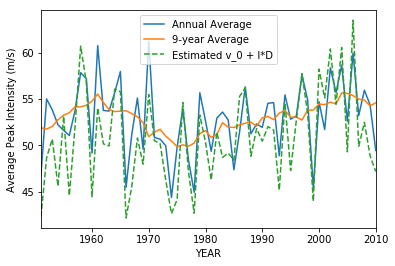

In [29]:
# v_max peak plot with 9-year average, and v_max estimated from intensification and duration
annual_cyclone_vmax = annual_cyclones[['YEAR','VMAX']]
nine_year_mean_cyclones_vmax = annual_cyclone_vmax
nine_year_mean_cyclones_vmax = nine_year_mean_cyclones_vmax.set_index('YEAR')

nine_year_mean_cyclones_vmax = nine_year_mean_cyclones_vmax.rolling(min_periods=1, window=9, center=True).mean()
nine_year_mean_cyclones_vmax = nine_year_mean_cyclones_vmax.reset_index()

annual_est_vmax = annual_cyclones[['YEAR','VMAX Estimated']]

ax = annual_cyclone_vmax.plot('YEAR', 'VMAX', label='Annual Average')
nine_year_mean_cyclones_vmax.plot('YEAR', 'VMAX', ax=ax, label='9-year Average')
annual_est_vmax.plot('YEAR', 'VMAX Estimated', ax=ax, ls = '--', label='Estimated v_0 + I*D')
plt.ylabel('Average Peak Intensity (m/s)')
plt.show()

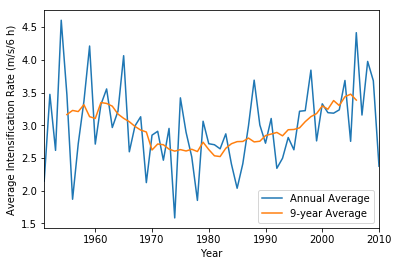

In [30]:
# Intensification plot with 9-year average
annual_int = annual_cyclones[['YEAR','Intensification']]
nine_year_cyclones_int = annual_int
nine_year_cyclones_int = nine_year_cyclones_int.set_index('YEAR')

nine_year_cyclones_int = nine_year_cyclones_int.rolling(min_periods=9, window=9, center=True).mean()
nine_year_cyclones_int = nine_year_cyclones_int.reset_index()

ax = annual_int.plot('YEAR', 'Intensification', label='Annual Average')
plt.ylabel('Average Intensification Rate (m/s/6 h)')
nine_year_cyclones_int.plot('YEAR', 'Intensification', ax=ax, label='9-year Average')
plt.xlabel('Year')
# plt.gcf().set_size_inches(10,10)
plt.show()

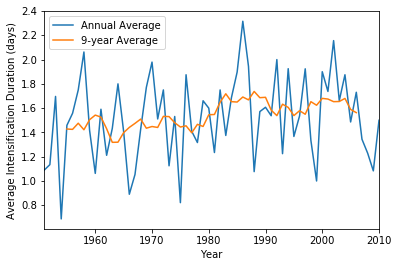

In [31]:
# Duration plot with 9-year average
annual_duration = annual_cyclones[['YEAR','Duration']]
nine_year_cyclones_duration = annual_duration
nine_year_cyclones_duration = nine_year_cyclones_duration.set_index('YEAR')

nine_year_cyclones_duration = nine_year_cyclones_duration.rolling(min_periods=9, window=9, center=True).mean()
nine_year_cyclones_duration = nine_year_cyclones_duration.reset_index()

ax = annual_duration.plot('YEAR', 'Duration', label='Annual Average')
plt.ylabel('Average Intensification Duration (days)')
nine_year_cyclones_duration.plot('YEAR', 'Duration', ax=ax, label='9-year Average')
plt.xlabel('Year')
# plt.gcf().set_size_inches(10,10)
plt.show()

In [32]:
# These parameters set the map dimensions
lats_N =  60.0
lats_S =   0.0
lons_W = 100.0
lons_E = 210.0
# Prevent discountinuity at final meridian
for i in range(0,np.size(LON, 0)):
   for j in range(0,np.size(LON, 1)):
      if LON[i,j] < 0:
         LON[i,j] = LON[i,j] + 360
# Box around relevant area
def draw_screen_poly(lats, lons, m):
    x, y = m(lons, lats)
    xy = zip(x,y)
    poly = Polygon(xy, facecolor = 'red', alpha=0.4)
    plt.gca().add_patch(poly)
lats = [LAT_lower_threshold, LAT_upper_threshold, LAT_upper_threshold, LAT_lower_threshold]
lons = [LON_lower_threshold, LON_lower_threshold, LON_upper_threshold, LON_upper_threshold]
# Set map plot background
plt.figure(figsize=(10,5))
m = Basemap(projection='cyl', llcrnrlat=lats_S, urcrnrlat=lats_N,llcrnrlon=lons_W, urcrnrlon=lons_E,
    resolution='l',lon_0=180)
m.drawcoastlines(linewidth=0.5)
m.drawcountries()
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff')
m.drawmeridians(np.arange(0,360,10),labels=[0,0,0,1],linewidth=0.5,fontsize=14)
m.drawparallels(np.arange(-90,90,10),labels=[1,0,0,0],linewidth=0.5,fontsize=14)
draw_screen_poly(lats, lons, m)

/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: All-NaN slice encountered
  This is separate from the ipykernel package so we can avoid doing imports until


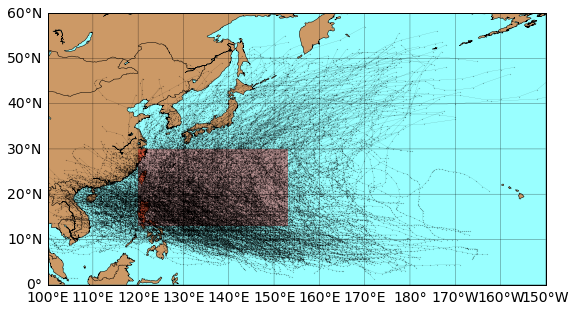

In [33]:
# Track plot
for i in range(np.size(season)):
    if (~np.isnan(np.nanmax(LON[i,:]))):
        plt.plot(LON[i,:],LAT[i,:],'ko--',markersize=0.1,linewidth=0.1)
plt.show()

In [34]:
pearsonr(annual_cyclones['VMAX'], annual_cyclones['VMAX Estimated'])

(0.8405089189198951, 4.5020291433259746e-17)